In [2]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib2 import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError
from sklearn.externals import joblib


import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    file = urlopen(url)

    img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

def make_resnet_conv(input_shape):
    '''
    Creates a ResNet50 model trained on ImageNet.
    It includes no final activation function,
    so model returns conv. features.
    
    `input_shape` is a tuple of integers.
    '''
    model = ResNet50(input_shape=input_shape, 
                     weights='imagenet', 
                     include_top=False)
    for layer in model.layers:
        layer.trainable = False   
    
    return model

In [5]:
def get_conv_feat(f, model):
    '''
    For any given image (file or url),
    convert to NumPy Array, resize to img_width x img_height,
    preprocess the values for ResNet, get the convolutional features
    from ResNet, and flatten the output.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    X_conv_2d = X_conv[0].flatten()
        
    return X_conv_2d

In [6]:
#TODO remove all afkikea 
meta_path = 'trial.csv'
X = pd.read_csv(meta_path)
print X.shape

/Users/robelmengistu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(15695, 2053)


In [7]:
X.product_id = X.product_id.astype(str)

In [8]:
X_afrikrea = X[X['product_id'].str.contains('afrikrea')]
print X_afrikrea.shape

(11194, 2053)


In [9]:
X_train = X[~X['product_id'].str.contains('afrikrea')]
X_train= X_train.reset_index(drop=True)

In [10]:
#X_train_conv_2d = X_train[[_ for _ in X_train.columns if "x_" in _]].values.astype(np.float)
X_train_conv_2d = X_train[[_ for _ in X_train.columns if "x_" in _]].values.astype(np.float)
X_train_conv_2d.shape

(4501, 2048)

In [11]:
col_names = ['filename', "gender", "category", "product_id"]
datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
X_train_urls = X_train[[_ for _ in X_train.columns if _ in col_names]].values

train_urls = []
for url_split in X_train_urls:
    url_a = datadir + "/".join(url_split)
    #print url_a
    train_urls.append(url_a)
print len(train_urls)
# path = datadir + J['gender'][k] + "/" +J['category'][k]+ "/" +str (J['product_id'][k])+"/" + J['filename'][k]


4501


In [12]:
feat_test = [X_train.loc[8][5:][_] for _ in range(len(X_train.loc[8][5:]))] 

In [13]:
J = pd.read_csv(meta_path, usecols=['filename', "gender", "category", "product_id"])
print J.shape

(15695, 4)


In [73]:
model_2 = make_resnet_conv(input_shape=[img_width, img_height, 3])
i = 0
CATEGORY = 6
cat_urls = []
cat_feats = []

for subdir, dirs, files in os.walk(datadir):
    for img in files: 
        if ".DS_" in img: continue
        path = subdir+"/" +img
        path_split = path.split("/")
        row = path_split[CATEGORY:]
        row = [str(i) for i in row]
        if row[0] == "others" or "afrikrea" in row[2]: continue
        feat = get_conv_feat(path, model_2).tolist()
        print "Extracted features for: ", row
        cat_feats.append(feat)
        if len(cat_feats) % 250 == 0:
            print "********************", len(cat_feats), "********************"
        cat_urls.append(datadir + "/".join(row))

print "cat_feats", len(cat_feats)
print "cat_urls", len(cat_urls)
        
delete_model(model_2)

Extracted features for:  ['men', 'men-blazers', '1804512449oo', '01804512449oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '1804512449oo', '11804512449oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38603128852oo', '038603128852oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38603128852oo', '138603128852oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38607290388oo', '038607290388oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38607290388oo', '138607290388oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38611943444oo', '038611943444oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38611943444oo', '138611943444oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38617382932oo', '038617382932oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '38617382932oo', '138617382932oo.jpeg']
Extracted features for:  ['men', 'men-blazers', '3960964103oo', '03960964103oo.jpeg']
Extracted features for:  ['men', 'men-

Extracted features for:  ['men', 'men-bottoms', '462090885oo', '0462090885oo.jpeg']
Extracted features for:  ['men', 'men-bottoms', '462090885oo', '1462090885oo.jpeg']
Extracted features for:  ['men', 'men-bottoms', '462090885oo', '2462090885oo.jpeg']
Extracted features for:  ['men', 'men-bottoms', '511311553oo', '0511311553oo.jpeg']
Extracted features for:  ['men', 'men-bottoms', '511311553oo', '1511311553oo.jpeg']
Extracted features for:  ['men', 'men-bottoms', '8658353927oo', '08658353927oo.jpeg']
Extracted features for:  ['men', 'men-bottoms', '8658353927oo', '18658353927oo.jpeg']
Extracted features for:  ['men', 'men-outwear', '69241962521', '0AziboMensAfricanPrintBomberJacketOrangeSteps.jpeg']
Extracted features for:  ['men', 'men-outwear', '69241962521', '1AziboMensAfricanPrintBomberJacketOrangeSteps.jpeg']
Extracted features for:  ['men', 'men-outwear', '69241962521', '2AziboMensAfricanPrintBomberJacketOrangeSteps.jpeg']
Extracted features for:  ['men', 'men-outwear', '69241962

Extracted features for:  ['men', 'men-tops', '2151958721oo', '02151958721oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151958721oo', '12151958721oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151958721oo', '22151958721oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151958721oo', '32151958721oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151994497oo', '02151994497oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151994497oo', '12151994497oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151994497oo', '22151994497oo.jpeg']
Extracted features for:  ['men', 'men-tops', '2151994497oo', '32151994497oo.jpeg']
Extracted features for:  ['men', 'men-tops', '248349458445wf', '0248349458445wf.jpeg']
Extracted features for:  ['men', 'men-tops', '248349458445wf', '1248349458445wf.jpeg']
Extracted features for:  ['men', 'men-tops', '248349458445wf', '2248349458445wf.jpeg']
Extracted features for:  ['men', 'men-tops', '248416698381wf', '02484166983

Extracted features for:  ['men', 'men-tops', '6192875398', '1DamiButtonUpAfricanPrintTrimShirtBlueYellowOrange.jpeg']
Extracted features for:  ['men', 'men-tops', '6575225413zd', '06575225413zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575225413zd', '16575225413zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575225413zd', '26575225413zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575225413zd', '36575225413zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575225413zd', '46575225413zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575333637zd', '06575333637zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575333637zd', '16575333637zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575333893zd', '06575333893zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575333893zd', '16575333893zd.jpeg']
Extracted features for:  ['men', 'men-tops', '6575333893zd', '26575333893zd.jpeg']
Extracted features for:  ['men', 'men-tops', '657533

Extracted features for:  ['women', 'women-dresses', '101357289497', '2AdisaAfricanPrintFormalDresswithStrapsBlackBlueYellowClearance.jpeg']
Extracted features for:  ['women', 'women-dresses', '101357289497', '3AdisaAfricanPrintFormalDresswithStrapsBlackBlueYellowClearance.jpeg']
Extracted features for:  ['women', 'women-dresses', '101357289497', '4AdisaAfricanPrintFormalDresswithStrapsBlackBlueYellowClearance.jpeg']
Extracted features for:  ['women', 'women-dresses', '101358534681', '0AdisaAfricanPrintFormalDresswithStrapsYellowBlackKente.jpeg']
Extracted features for:  ['women', 'women-dresses', '101358534681', '1AdisaAfricanPrintFormalDresswithStrapsYellowBlackKente.jpeg']
Extracted features for:  ['women', 'women-dresses', '101358534681', '2AdisaAfricanPrintFormalDresswithStrapsYellowBlackKente.jpeg']
Extracted features for:  ['women', 'women-dresses', '101358534681', '3AdisaAfricanPrintFormalDresswithStrapsYellowBlackKente.jpeg']
Extracted features for:  ['women', 'women-dresses', 

Extracted features for:  ['women', 'women-dresses', '11500625103', '4nessa-african-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11500625103', '5nessa-african-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11500625103', '6nessa-african-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11500625103', '7nessa-african-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11500760207', '0josiane-african-print-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11500760207', '1josiane-african-print-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11500760207', '2josiane-african-print-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11627861647', '0dinka-african-print-dress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', '116354351129', '0MeriaAfricanPrintMidiPencilDresswithStretchBlueYellowBlack.jpeg']
Extracted features for:  ['women', 'women-dr

Extracted features for:  ['women', 'women-dresses', '11887397967', '1african-print-thema-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11887397967', '2african-print-thema-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11890824527', '0african-print-juma-midi-dress.jpeg']
******************** 500 ********************
Extracted features for:  ['women', 'women-dresses', '11890824527', '1african-print-juma-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11890824527', '2african-print-juma-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11890848591', '0african-print-oluwa-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11890848591', '1african-print-oluwa-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11890848591', '2african-print-oluwa-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '11890848591', '3african-print-oluwa-midi-dress.j

Extracted features for:  ['women', 'women-dresses', '147095420943', '1pre-order-african-print-pikine-midi-dressavailable-to-ship-december-22.jpeg']
Extracted features for:  ['women', 'women-dresses', '147095420943', '2pre-order-african-print-pikine-midi-dressavailable-to-ship-december-22.jpeg']
Extracted features for:  ['women', 'women-dresses', '147095420943', '3pre-order-african-print-pikine-midi-dressavailable-to-ship-december-22.jpeg']
Extracted features for:  ['women', 'women-dresses', '147095420943', '4pre-order-african-print-pikine-midi-dressavailable-to-ship-december-22.jpeg']
Extracted features for:  ['women', 'women-dresses', '147095420943', '5pre-order-african-print-pikine-midi-dressavailable-to-ship-december-22.jpeg']
Extracted features for:  ['women', 'women-dresses', '147104661519', '0dagana-african-print-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '147104661519', '1dagana-african-print-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-

Extracted features for:  ['women', 'women-dresses', '2096962693zd', '32096962693zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '2096962693zd', '42096962693zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '2096973189zd', '02096973189zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '2096973189zd', '12096973189zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '2096973189zd', '22096973189zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '2096973189zd', '32096973189zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215291337zd', '0215291337zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215291337zd', '1215291337zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215291337zd', '2215291337zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215291337zd', '3215291337zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215291337zd', '4215291337zd.jpeg']
Extracted features f

Extracted features for:  ['women', 'women-dresses', '215297653zd', '1215297653zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297653zd', '2215297653zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297653zd', '3215297653zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297653zd', '4215297653zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297653zd', '5215297653zd.jpeg']
******************** 750 ********************
Extracted features for:  ['women', 'women-dresses', '215297653zd', '6215297653zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297677zd', '0215297677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297677zd', '1215297677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297677zd', '2215297677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297677zd', '3215297677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '215297677zd', '421529

Extracted features for:  ['women', 'women-dresses', '269541048333wf', '0269541048333wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269541048333wf', '1269541048333wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269541048333wf', '2269541048333wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269541048333wf', '3269541048333wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269541048333wf', '4269541048333wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269562839053wf', '0269562839053wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269562839053wf', '1269562839053wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269562839053wf', '2269562839053wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269562839053wf', '3269562839053wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '269562839053wf', '4269562839053wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '2695628

Extracted features for:  ['women', 'women-dresses', '279959371789wf', '1279959371789wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '279959371789wf', '2279959371789wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '279961632781wf', '0279961632781wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '279961632781wf', '1279961632781wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '279961632781wf', '2279961632781wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '280634425357wf', '0280634425357wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '280634425357wf', '1280634425357wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '280634425357wf', '2280634425357wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '280642715661wf', '0280642715661wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '280666570765wf', '0280666570765wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '2807114

Extracted features for:  ['women', 'women-dresses', '314604617741wf', '0314604617741wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314604617741wf', '1314604617741wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314604617741wf', '2314604617741wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314604617741wf', '3314604617741wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314608910349wf', '0314608910349wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314608910349wf', '1314608910349wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314609664013wf', '0314609664013wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314609664013wf', '1314609664013wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314611761165wf', '0314611761165wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '314611761165wf', '1314611761165wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '3146144

Extracted features for:  ['women', 'women-dresses', '317997937zd', '1317997937zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317997937zd', '2317997937zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317997937zd', '3317997937zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317997937zd', '4317997937zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317997937zd', '5317997937zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317998977zd', '0317998977zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317998977zd', '1317998977zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317998977zd', '2317998977zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317999001zd', '0317999001zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317999001zd', '1317999001zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '317999001zd', '2317999001zd.jpeg']
Extracted features for:  ['women

Extracted features for:  ['women', 'women-dresses', '326588071949wf', '0326588071949wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '326588071949wf', '1326588071949wf.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680677zd', '0327680677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680677zd', '1327680677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680677zd', '2327680677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680677zd', '3327680677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680677zd', '4327680677zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680741zd', '0327680741zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680741zd', '1327680741zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680741zd', '2327680741zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '327680741zd', '3327680741zd.jpeg']
Extracted features f

Extracted features for:  ['women', 'women-dresses', '44247678991', '3pre-order-seyi-corset-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44247678991', '4pre-order-seyi-corset-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44249448463', '0african-print-crystal-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44249448463', '1african-print-crystal-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44249448463', '2african-print-crystal-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44249448463', '3african-print-crystal-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44249448463', '4african-print-crystal-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '44249448463', '5african-print-crystal-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '451591684zd', '0451591684zd.jpeg']
Extracted features for:  ['women', 'women-dresses'

Extracted features for:  ['women', 'women-dresses', '6521389701ow', '36521389701ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521389701ow', '46521389701ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521389701ow', '56521389701ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521572485ow', '06521572485ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521572485ow', '16521572485ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521572485ow', '26521572485ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521572485ow', '36521572485ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6521572485ow', '46521572485ow.jpeg']
Extracted features for:  ['women', 'women-dresses', '6523422021zd', '06523422021zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '6523422021zd', '16523422021zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '6523422021zd', '26523422021zd.jpeg']
Extracted 

Extracted features for:  ['women', 'women-dresses', '7091694725zd', '27091694725zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7091694725zd', '37091694725zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7176301893zd', '07176301893zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7176301893zd', '17176301893zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7176301893zd', '27176301893zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7177580357zd', '07177580357zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7177580357zd', '17177580357zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7177580357zd', '27177580357zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7177580357zd', '37177580357zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7177580357zd', '47177580357zd.jpeg']
Extracted features for:  ['women', 'women-dresses', '7297658181zd', '07297658181zd.jpeg']
Extracted 

Extracted features for:  ['women', 'women-dresses', '83111215119', '2african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83111215119', '3african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83111215119', '4african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83111215119', '5african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83111215119', '6african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83111215119', '7african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83111215119', '8african-print-katina-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83116261391', '0african-print-otavi-mini-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', '83116261391', '1african-print-otavi-mini-dress.jpeg']
Extracted features for:  ['wom

Extracted features for:  ['women', 'women-dresses', 'bemi-hi-low-dress', '2bemi-hi-low-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'bemi-hi-low-dress', '3bemi-hi-low-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'bemi-hi-low-dress', '4bemi-hi-low-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'blue-annie-dress', '0blue-annie-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'blue-annie-dress', '1blue-annie-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'blue-annie-dress', '2blue-annie-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'blue-annie-dress', '3blue-annie-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'bola-shirt-dress', '0bola-shirt-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'bola-shirt-dress', '1bola-shirt-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'bola-shirt-dress', '2bola-shirt-dress.jpeg']
Extracted feat

Extracted features for:  ['women', 'women-dresses', 'lex-maxi-dress', '3lex-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lex-maxi-dress', '4lex-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '0lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '1lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '2lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '3lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '4lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '5lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '6lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '7lexi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'lexi-dress', '8lexi-dress.jpeg']
Extracted features for:  ['women', 'wo

Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-purple', '3maxi-infinity-in-purple.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-purple', '4maxi-infinity-in-purple.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-purple', '5maxi-infinity-in-purple.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-red-umbrella', '0maxi-infinity-in-red-umbrella.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-red-umbrella', '1maxi-infinity-in-red-umbrella.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-red-umbrella', '2maxi-infinity-in-red-umbrella.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-red-umbrella', '3maxi-infinity-in-red-umbrella.jpeg']
Extracted features for:  ['women', 'women-dresses', 'maxi-infinity-in-red-umbrella', '4maxi-infinity-in-red-umbrella.jpeg']
Extracted features for:  ['women', 'women-dr

Extracted features for:  ['women', 'women-dresses', 'ose-midi-dress', '1ose-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'ose-midi-dress', '2ose-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'ose-midi-dress', '3ose-midi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'queen-sweatdress-1', '0queen-sweatdress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', 'queen-sweatdress-1', '1queen-sweatdress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', 'queen-sweatdress-1', '2queen-sweatdress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', 'queen-sweatdress-1', '3queen-sweatdress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', 'queen-sweatdress-2', '0queen-sweatdress-2.jpeg']
Extracted features for:  ['women', 'women-dresses', 'queen-sweatdress-2', '1queen-sweatdress-2.jpeg']
Extracted features for:  ['women', 'women-dresses', 'rimi-mini-dress', '0rimi-mini-dress.jpeg']
Extracted 

Extracted features for:  ['women', 'women-dresses', 'yene-mini-dress-1', '5yene-mini-dress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yene-mini-dress-1', '6yene-mini-dress-1.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yeti-maxi-dress', '0yeti-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yeti-maxi-dress', '1yeti-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yeti-maxi-dress', '2yeti-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yeti-maxi-dress', '3yeti-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yinka-maxi-dress', '0yinka-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yinka-maxi-dress', '1yinka-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'yinka-maxi-dress', '2yinka-maxi-dress.jpeg']
Extracted features for:  ['women', 'women-dresses', 'zuri-hi-low-dress', '0zuri-hi-low-dress.jpeg']
Extracted features for

Extracted features for:  ['women', 'women-jackets', '326207275021wf', '1326207275021wf.jpeg']
Extracted features for:  ['women', 'women-jackets', '326207275021wf', '2326207275021wf.jpeg']
Extracted features for:  ['women', 'women-jackets', '326208421901wf', '0326208421901wf.jpeg']
Extracted features for:  ['women', 'women-jackets', '326208421901wf', '1326208421901wf.jpeg']
Extracted features for:  ['women', 'women-jackets', '326209798157wf', '0326209798157wf.jpeg']
Extracted features for:  ['women', 'women-jackets', '326209798157wf', '1326209798157wf.jpeg']
Extracted features for:  ['women', 'women-jackets', '351097589zd', '0351097589zd.jpeg']
Extracted features for:  ['women', 'women-jackets', '351097589zd', '1351097589zd.jpeg']
Extracted features for:  ['women', 'women-jackets', '351097589zd', '2351097589zd.jpeg']
Extracted features for:  ['women', 'women-jackets', '351097589zd', '3351097589zd.jpeg']
Extracted features for:  ['women', 'women-jackets', '351097589zd', '4351097589zd.jpe

Extracted features for:  ['women', 'women-jackets', 'fike-jacket', '1fike-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'fike-jacket', '2fike-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'fike-jacket', '3fike-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'fike-jacket', '4fike-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'fike-jacket', '5fike-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'fike-jacket', '6fike-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'jojo-reversible-bomber-jacket', '0jojo-reversible-bomber-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'jojo-reversible-bomber-jacket', '1jojo-reversible-bomber-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'jojo-reversible-bomber-jacket', '2jojo-reversible-bomber-jacket.jpeg']
Extracted features for:  ['women', 'women-jackets', 'jojo-reversible-bomber-jacket', '3jojo-reversib

Extracted features for:  ['women', 'women-jumpsuits', '11901695823', '2african-print-seriwa-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '11901695823', '3african-print-seriwa-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '11901695823', '4african-print-seriwa-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '125011558415', '0african-print-basil-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '125011558415', '1african-print-basil-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '125011558415', '2african-print-basil-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '125011558415', '3african-print-basil-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '125011558415', '4african-print-basil-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '216955879439', '0african-print-darcelle-jumpsuit.jpeg']
Extracted features for:  

Extracted features for:  ['women', 'women-jumpsuits', '77850640399', '3african-print-shun-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '0african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '1african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '2african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '3african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '4african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '5african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '77866139663', '6african-print-connie-jumpsuit.jpeg']
Extracted features for:  ['women', 'women-jumpsuits', '80208134159', '0african-print-malawi-jumpsuit.jpeg']
Extracted features for:  ['wom

Extracted features for:  ['women', 'women-matching-sets', '215296001zd', '4215296001zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296093zd', '0215296093zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296093zd', '1215296093zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296093zd', '2215296093zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296093zd', '3215296093zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296093zd', '4215296093zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296209zd', '0215296209zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296209zd', '1215296209zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296209zd', '2215296209zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '215296209zd', '3215296209zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '2

Extracted features for:  ['women', 'women-matching-sets', '57640976399', '6african-print-lissa-pencil-skirt.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6808747077zd', '06808747077zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6808747077zd', '16808747077zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6808747077zd', '26808747077zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6808747077zd', '36808747077zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6808747077zd', '46808747077zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6809873157zd', '06809873157zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6809873157zd', '16809873157zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6809873157zd', '26809873157zd.jpeg']
Extracted features for:  ['women', 'women-matching-sets', '6809873157zd', '36809873157zd.jpeg']
Extracted features fo

Extracted features for:  ['women', 'women-outerwear', '8819748428', '4DiolaAfricanPrintBlazerwithAquaCircles.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9079987596', '0DiolaAfricanPrintPeplumBlazerTanGreen.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9079987596', '1DiolaAfricanPrintPeplumBlazerTanGreen.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9079987596', '2DiolaAfricanPrintPeplumBlazerTanGreen.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9079987596', '3DiolaAfricanPrintPeplumBlazerTanGreen.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9080002636', '0DiolaAfricanPrintPeplumBlazerYellowOrange.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9080002636', '1DiolaAfricanPrintPeplumBlazerYellowOrange.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9080002636', '2DiolaAfricanPrintPeplumBlazerYellowOrange.jpeg']
Extracted features for:  ['women', 'women-outerwear', '9080002636',

Extracted features for:  ['women', 'women-pants-and-shorts', '110718844953', '3BintyWomensAfricanPrintSideStripeJoggersYellowRedSwirls.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116444856345', '0TamelaAfricanPrintJumpsuitBlueOrangeYellow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116444856345', '1TamelaAfricanPrintJumpsuitBlueOrangeYellow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116444856345', '2TamelaAfricanPrintJumpsuitBlueOrangeYellow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116444856345', '3TamelaAfricanPrintJumpsuitBlueOrangeYellow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116444856345', '4TamelaAfricanPrintJumpsuitBlueOrangeYellow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116444856345', '5TamelaAfricanPrintJumpsuitBlueOrangeYellow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '116477788185', '0Tamel

Extracted features for:  ['women', 'women-pants-and-shorts', '6503004869ow', '16503004869ow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '6503004869ow', '26503004869ow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '6503004869ow', '36503004869ow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '6503004869ow', '46503004869ow.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '69269880857', '0MonifaAfricanPrintHighWaistWideLegPantsBlueOrangeTrianglesAnkaraWaxPrint.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '69269880857', '1MonifaAfricanPrintHighWaistWideLegPantsBlueOrangeTrianglesAnkaraWaxPrint.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '69349769241', '0MonifaAfricanPrintHighWaistWideLegPantsBlueCirclesAnkaraWaxPrint.jpeg']
Extracted features for:  ['women', 'women-pants-and-shorts', '69349769241', '1MonifaAfricanPrintHighWaistWideLegPantsBlueCirclesAnkaraWaxP

Extracted features for:  ['women', 'women-skirts', '11083160780', '3LelosaAfricanPrintChiffonMaxiSkirtBlueGreenDiamondsClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083403212', '0LelosaAfricanPrintChiffonMaxiSkirtRedGreenKenteClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083403212', '1LelosaAfricanPrintChiffonMaxiSkirtRedGreenKenteClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083403212', '2LelosaAfricanPrintChiffonMaxiSkirtRedGreenKenteClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083403212', '3LelosaAfricanPrintChiffonMaxiSkirtRedGreenKenteClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083539340', '0LelosaAfricanPrintChiffonMaxiSkirtBlueRaspberryClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083539340', '1LelosaAfricanPrintChiffonMaxiSkirtBlueRaspberryClearance.jpeg']
Extracted features for:  ['women', 'women-skirts', '11083539340', '2Lelo

Extracted features for:  ['women', 'women-skirts', '269789560845wf', '3269789560845wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269789560845wf', '4269789560845wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269803290637wf', '0269803290637wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269803290637wf', '1269803290637wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269803290637wf', '2269803290637wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269803290637wf', '3269803290637wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269803290637wf', '4269803290637wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269832749069wf', '0269832749069wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269832749069wf', '1269832749069wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269832749069wf', '2269832749069wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '269832749069wf', '

Extracted features for:  ['women', 'women-skirts', '317998369zd', '1317998369zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998369zd', '2317998369zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998369zd', '3317998369zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998369zd', '4317998369zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998777zd', '0317998777zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998777zd', '1317998777zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998777zd', '2317998777zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '317998777zd', '3317998777zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '321193017357wf', '0321193017357wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '321193017357wf', '1321193017357wf.jpeg']
Extracted features for:  ['women', 'women-skirts', '321193017357wf', '2321193017357wf.jpeg']
Extracted features for:  

Extracted features for:  ['women', 'women-skirts', '468149363', '3AmsaAfricanPrintMidiSkirtwithSashYellowBlue.jpeg']
Extracted features for:  ['women', 'women-skirts', '468149363', '4AmsaAfricanPrintMidiSkirtwithSashYellowBlue.jpeg']
Extracted features for:  ['women', 'women-skirts', '468149363', '5AmsaAfricanPrintMidiSkirtwithSashYellowBlue.jpeg']
Extracted features for:  ['women', 'women-skirts', '4832656774', '0DashikiAfricanPrintMaxiSkirtBlackRedishOrange.jpeg']
Extracted features for:  ['women', 'women-skirts', '4832656774', '1DashikiAfricanPrintMaxiSkirtBlackRedishOrange.jpeg']
Extracted features for:  ['women', 'women-skirts', '4832656774', '2DashikiAfricanPrintMaxiSkirtBlackRedishOrange.jpeg']
Extracted features for:  ['women', 'women-skirts', '4832656774', '3DashikiAfricanPrintMaxiSkirtBlackRedishOrange.jpeg']
Extracted features for:  ['women', 'women-skirts', '500166724zd', '0500166724zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '500166724zd', '1500166724zd.jp

Extracted features for:  ['women', 'women-skirts', '6639177222', '3LolaAfricanPrintHighlowSkirtGoldPinkGreen.jpeg']
Extracted features for:  ['women', 'women-skirts', '6639177222', '4LolaAfricanPrintHighlowSkirtGoldPinkGreen.jpeg']
Extracted features for:  ['women', 'women-skirts', '6640238150', '0LorisaAfricanPrintMaxiSkirtwithSlitOrangeGreenTan.jpeg']
Extracted features for:  ['women', 'women-skirts', '6640238150', '1LorisaAfricanPrintMaxiSkirtwithSlitOrangeGreenTan.jpeg']
Extracted features for:  ['women', 'women-skirts', '6640238150', '2LorisaAfricanPrintMaxiSkirtwithSlitOrangeGreenTan.jpeg']
Extracted features for:  ['women', 'women-skirts', '6640238150', '3LorisaAfricanPrintMaxiSkirtwithSlitOrangeGreenTan.jpeg']
Extracted features for:  ['women', 'women-skirts', '6689792326', '0ChicAfricanPrintMaxiSkirtPeacockFeather.jpeg']
Extracted features for:  ['women', 'women-skirts', '6689792326', '1ChicAfricanPrintMaxiSkirtPeacockFeather.jpeg']
Extracted features for:  ['women', 'women-sk

Extracted features for:  ['women', 'women-skirts', '7194092550', '5NayaAfricanPrintDashikiMidiSkirtwithSashLimeGreen.jpeg']
Extracted features for:  ['women', 'women-skirts', '7194092550', '6NayaAfricanPrintDashikiMidiSkirtwithSashLimeGreen.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297454981zd', '07297454981zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297454981zd', '17297454981zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297454981zd', '27297454981zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297568837zd', '07297568837zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297568837zd', '17297568837zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297568837zd', '27297568837zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7297568837zd', '37297568837zd.jpeg']
Extracted features for:  ['women', 'women-skirts', '7386019846', '0NayaAfricanPrintDashikiMidiSkirtwithSashOrange.jpeg']
Extracte

Extracted features for:  ['women', 'women-skirts', '9205295628', '1NayaAfricanPrintDashikiMidiSkirtwithSashPurple.jpeg']
Extracted features for:  ['women', 'women-skirts', '92536143897', '0HasanaStretchAfricanPrintPencilMidiSkirtyellowblackKente.jpeg']
Extracted features for:  ['women', 'women-skirts', '92536143897', '1HasanaStretchAfricanPrintPencilMidiSkirtyellowblackKente.jpeg']
Extracted features for:  ['women', 'women-skirts', '92536143897', '2HasanaStretchAfricanPrintPencilMidiSkirtyellowblackKente.jpeg']
Extracted features for:  ['women', 'women-skirts', '92536143897', '3HasanaStretchAfricanPrintPencilMidiSkirtyellowblackKente.jpeg']
Extracted features for:  ['women', 'women-skirts', '92544991257', '0HasanaAfricanPrintPencilMidiSkirtOrangeSteps.jpeg']
Extracted features for:  ['women', 'women-skirts', '92544991257', '1HasanaAfricanPrintPencilMidiSkirtOrangeSteps.jpeg']
Extracted features for:  ['women', 'women-skirts', '92544991257', '2HasanaAfricanPrintPencilMidiSkirtOrangeStep

Extracted features for:  ['women', 'women-skirts', 'ese-maxi-skirt', '2ese-maxi-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'ese-maxi-skirt', '3ese-maxi-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'ese-maxi-skirt', '4ese-maxi-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'esther-skirt', '0esther-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'esther-skirt', '1esther-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'esther-skirt', '2esther-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'esther-skirt', '3esther-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'femi-skirt', '0femi-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'femi-skirt', '1femi-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'igho-midi-skirt', '0igho-midi-skirt.jpeg']
Extracted features for:  ['women', 'women-skirts', 'igho-midi-skirt', '1igho-midi-skirt.jpeg']
Extra

Extracted features for:  ['women', 'women-swimwear', 'ama', '1ama.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ama', '2ama.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ama-bottom', '0ama-bottom.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ama-bottom', '1ama-bottom.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ama-bottom', '2ama-bottom.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ebi', '0ebi.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ebi', '1ebi.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ebi', '2ebi.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'ebi', '3ebi.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'esosa', '0esosa.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'esosa', '1esosa.jpeg']
Extracted features for:  ['women', 'women-swimwear', 'esosa-bottom-plus', '0esosa-bottom-plus.jpeg']
Extracted features for:  ['women', 'women-swim

Extracted features for:  ['women', 'women-tops', '11073169740', '1OlaAfricanPrintOfftheShoulderPuffSleeveTopRedYellowClearance.jpeg']
Extracted features for:  ['women', 'women-tops', '11073169740', '2OlaAfricanPrintOfftheShoulderPuffSleeveTopRedYellowClearance.jpeg']
Extracted features for:  ['women', 'women-tops', '11073230668', '0OlaAfricanPrintOfftheShoulderPuffSleeveTopYellowOrangeClearance.jpeg']
Extracted features for:  ['women', 'women-tops', '11073230668', '1OlaAfricanPrintOfftheShoulderPuffSleeveTopYellowOrangeClearance.jpeg']
Extracted features for:  ['women', 'women-tops', '11073230668', '2OlaAfricanPrintOfftheShoulderPuffSleeveTopYellowOrangeClearance.jpeg']
Extracted features for:  ['women', 'women-tops', '11073230668', '3OlaAfricanPrintOfftheShoulderPuffSleeveTopYellowOrangeClearance.jpeg']
Extracted features for:  ['women', 'women-tops', '11073254924', '0OlaAfricanPrintOfftheShoulderPuffSleeveTopTurquoiseRaspberryClearance.jpeg']
Extracted features for:  ['women', 'women

Extracted features for:  ['women', 'women-tops', '11658785551', '0kotto-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11658785551', '1kotto-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11716258447', '0fusap-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11716258447', '1fusap-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11716258447', '2fusap-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11716258447', '3fusap-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11716258447', '4fusap-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11716258447', '5fusap-african-print-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11890922063', '0african-print-dasmina-yonas-top.jpeg']
Extracted features for:  ['women', 'women-tops', '11890922063', '1african-print-dasmina-yonas-top.jpeg']
Extracted feat

Extracted features for:  ['women', 'women-tops', '147074908175', '5yellow-african-print-sweatshirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '0khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '1khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '2khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '3khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '4khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '5khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '19009241103', '6khufu-african-print-shirt.jpeg']
Extracted features for:  ['women', 'women-tops', '215291369zd', '0215291369zd.jpeg']
Extracted features for:  ['women', 'women-tops', '215291369zd', '1215291369zd.jpeg']
Extracted features for:  ['wome

Extracted features for:  ['women', 'women-tops', '280417501197wf', '1280417501197wf.jpeg']
Extracted features for:  ['women', 'women-tops', '280417501197wf', '2280417501197wf.jpeg']
Extracted features for:  ['women', 'women-tops', '280417501197wf', '3280417501197wf.jpeg']
Extracted features for:  ['women', 'women-tops', '280749801485wf', '0280749801485wf.jpeg']
Extracted features for:  ['women', 'women-tops', '280749801485wf', '1280749801485wf.jpeg']
Extracted features for:  ['women', 'women-tops', '281245122573wf', '0281245122573wf.jpeg']
Extracted features for:  ['women', 'women-tops', '281245122573wf', '1281245122573wf.jpeg']
Extracted features for:  ['women', 'women-tops', '281245122573wf', '2281245122573wf.jpeg']
Extracted features for:  ['women', 'women-tops', '281245122573wf', '3281245122573wf.jpeg']
Extracted features for:  ['women', 'women-tops', '281245122573wf', '4281245122573wf.jpeg']
Extracted features for:  ['women', 'women-tops', '281245122573wf', '5281245122573wf.jpeg']

Extracted features for:  ['women', 'women-tops', '331451138061wf', '1331451138061wf.jpeg']
Extracted features for:  ['women', 'women-tops', '331451138061wf', '2331451138061wf.jpeg']
Extracted features for:  ['women', 'women-tops', '331460870157wf', '0331460870157wf.jpeg']
Extracted features for:  ['women', 'women-tops', '331460870157wf', '1331460870157wf.jpeg']
Extracted features for:  ['women', 'women-tops', '343237085zd', '0343237085zd.jpeg']
Extracted features for:  ['women', 'women-tops', '343237085zd', '1343237085zd.jpeg']
Extracted features for:  ['women', 'women-tops', '343237085zd', '2343237085zd.jpeg']
Extracted features for:  ['women', 'women-tops', '343237085zd', '3343237085zd.jpeg']
Extracted features for:  ['women', 'women-tops', '343237085zd', '4343237085zd.jpeg']
Extracted features for:  ['women', 'women-tops', '343237369zd', '0343237369zd.jpeg']
Extracted features for:  ['women', 'women-tops', '343237369zd', '1343237369zd.jpeg']
Extracted features for:  ['women', 'women

Extracted features for:  ['women', 'women-tops', '462107601oo', '2462107601oo.jpeg']
Extracted features for:  ['women', 'women-tops', '6222525254', '0BlackOfftheShoulderTop.jpeg']
Extracted features for:  ['women', 'women-tops', '6222525254', '1BlackOfftheShoulderTop.jpeg']
Extracted features for:  ['women', 'women-tops', '6222525254', '2BlackOfftheShoulderTop.jpeg']
Extracted features for:  ['women', 'women-tops', '6326576519oo', '06326576519oo.jpeg']
Extracted features for:  ['women', 'women-tops', '6326576519oo', '16326576519oo.jpeg']
Extracted features for:  ['women', 'women-tops', '6326603783oo', '06326603783oo.jpeg']
Extracted features for:  ['women', 'women-tops', '6326603783oo', '16326603783oo.jpeg']
Extracted features for:  ['women', 'women-tops', '6494000069ow', '06494000069ow.jpeg']
Extracted features for:  ['women', 'women-tops', '6494000069ow', '16494000069ow.jpeg']
Extracted features for:  ['women', 'women-tops', '6494000069ow', '26494000069ow.jpeg']
Extracted features fo

Extracted features for:  ['women', 'women-tops', '7205394949zd', '07205394949zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205394949zd', '17205394949zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205394949zd', '27205394949zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205394949zd', '37205394949zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205394949zd', '47205394949zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205491525zd', '07205491525zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205491525zd', '17205491525zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205491525zd', '27205491525zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205491525zd', '37205491525zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7205491525zd', '47205491525zd.jpeg']
Extracted features for:  ['women', 'women-tops', '7478874566', '0AmaraWomensDashikiTShirtWhite.jpeg']
Extracted features for:  ['w

Extracted features for:  ['women', 'women-tops', '9385134796', '0AmadiAfricanPrintSleevelessTopGoldPinkGreen.jpeg']
Extracted features for:  ['women', 'women-tops', '9385134796', '1AmadiAfricanPrintSleevelessTopGoldPinkGreen.jpeg']
Extracted features for:  ['women', 'women-tops', '9385134796', '2AmadiAfricanPrintSleevelessTopGoldPinkGreen.jpeg']
Extracted features for:  ['women', 'women-tops', '9385134796', '3AmadiAfricanPrintSleevelessTopGoldPinkGreen.jpeg']
Extracted features for:  ['women', 'women-tops', '9385167436', '0AmadiAfricanPrintSleevelessTopRedGold.jpeg']
Extracted features for:  ['women', 'women-tops', '9385167436', '1AmadiAfricanPrintSleevelessTopRedGold.jpeg']
Extracted features for:  ['women', 'women-tops', '9385167436', '2AmadiAfricanPrintSleevelessTopRedGold.jpeg']
Extracted features for:  ['women', 'women-tops', '9385249548', '0AmadiAfricanPrintSleevelessTopPinkBeige.jpeg']
Extracted features for:  ['women', 'women-tops', '9385249548', '1AmadiAfricanPrintSleevelessTo

Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-red', '1oby-hi-low-top-in-red.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-red', '2oby-hi-low-top-in-red.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-red', '3oby-hi-low-top-in-red.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-red', '4oby-hi-low-top-in-red.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-white', '0oby-hi-low-top-in-white.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-white', '1oby-hi-low-top-in-white.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-white', '2oby-hi-low-top-in-white.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-hi-low-top-in-white', '3oby-hi-low-top-in-white.jpeg']
Extracted features for:  ['women', 'women-tops', 'oby-top-in-patchwork', '0oby-top-in-patchwork.jpeg']
Extracted features for:  ['women', 'women

Extracted features for:  ['women', 'women-tops', 'tiwa-top-in-pink-timi', '2tiwa-top-in-pink-timi.jpeg']
Extracted features for:  ['women', 'women-tops', 'tiwa-top-in-red', '0tiwa-top-in-red.jpeg']
Extracted features for:  ['women', 'women-tops', 'tiwa-top-in-red', '1tiwa-top-in-red.jpeg']
Extracted features for:  ['women', 'women-tops', 'tofi-top', '0tofi-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'tofi-top', '1tofi-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'toju-crop-top', '0toju-crop-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'toju-crop-top', '1toju-crop-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'toju-crop-top', '2toju-crop-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'toni-crop-top', '0toni-crop-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'toni-crop-top', '1toni-crop-top.jpeg']
Extracted features for:  ['women', 'women-tops', 'toni-crop-top', '2toni-crop-top.jpeg']
Extracted feature

In [75]:
cat_urls.index("/Users/robelmengistu/Documents/CS230_project/data/women/women-skirts/468149363/2AmsaAfricanPrintMidiSkirtwithSashYellowBlue.jpeg")

2959

In [92]:
cat_2d_feat = np.asarray(cat_feats)

(4501, 2048)


In [95]:
#Training KNN on 100K images w/ 2K features takes about 2 minutes!
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=30, n_jobs=8, algorithm='ball_tree')
knn.fit(cat_2d_feat)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=30, p=2, radius=1.0)

In [18]:
#knn.kneighbors([X, 8, return_distance=True])

In [96]:
#serialize 
from sklearn.externals import joblib
knn_file = 'triplet_cate.pkl'
joblib.dump(knn, knn_file)

['triplet_cate.pkl']

In [97]:
def get_conv_feats(f, model):
    '''
    Converts an image (str of path or url) to a 2d convolutional features AKA logit.
    '''
    img = read_img(f)
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    X = preprocess_input(np.expand_dims(np_img, axis=0).astype(np.float))
    X_conv = model.predict(X)
    new_shape = (X_conv.shape[0], np.prod(X_conv.shape[1:]))
    X_conv_2d = X_conv.reshape(new_shape)
    return X_conv_2d

In [103]:
def get_n_set():
    n_set = []
    for train_data in cat_2d_feat: 
        n_set.append(knn.kneighbors(train_data.reshape(1, train_data.shape[0]), return_distance=True))
        if len(n_set) % 500 == 0:
            print len(n_set)
    return n_set

In [104]:
train_n_set = get_n_set()

500
1000
1500
2000
2500
3000
3500
4000


In [127]:
def plot_neighbors(url, neighbors, cat_urls, top=8, per_row=4):
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    path_split = url.split("/")
    query_category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    print "Query: ", query_category
    img = read_img(url) # reads an image link into a NumPy array...
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    imshow(np_img)
    
    c = 0 
    i = 0 
    product_recommended = []
    while (True):
        if c == top: break 
        if c % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = c % 4
        k = neighbors[1][0][i]

        #path = datadir + J['gender'][k] + "/" +J['category'][k]+ "/" +str (J['product_id'][k])+"/" + J['filename'][k]

        pd_id = cat_urls[k].split("/")[CATEGORY_INDEX + 1]
        pd_cat = cat_urls[k].split("/")[CATEGORY_INDEX] 
        path = cat_urls[k]
        image = read_img(path)
        if pd_id in product_recommended: 
            i += 1
            continue
        i += 1
        c += 1
        product_recommended.append(pd_id)
        score = accuracy_score (query_category, pd_cat, top)
        
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')    
        ax[j].annotate(pd_cat + "   score: "+ str(score * top)+ "  "+str(distance[i - 1]),
                      (0,0), (0, -32), xycoords='axes fraction', 
                       textcoords='offset points', va='top')
  

        

In [174]:
# calc the mean avg. precision
def get_triplets(url, neighbors, cat_urls, num_rec=8, per_row=4):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    PID_INDEX = 8
    query_category = path_split[CATEGORY_INDEX]
    #print "query_category: ", query_category
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
   # MAP = 0 
   # accuracy = [] 
    #product_recommended = []
    neg_count = 0 
    neg_paths = []
    pos_paths = []
    while (True):
        if c == num_rec: break 
        k = neighbors[1][0][i]
        #print k, X_train['product_id'][k]

        pd_id = cat_urls[k].split("/")[PID_INDEX]
        pd_cat = cat_urls[k].split("/")[CATEGORY_INDEX] 
#         if pd_id in product_recommended: 
#             i += 1
#             continue
        
#         accuracy.append(accuracy_score(query_category, pd_cat, num_rec)
#         MAP += (sum(accuracy)/len(accuracy))
#        print c, ": ", pd_cat
        
        if pd_cat == query_category: pos_paths.append(cat_urls[k])
        else: neg_paths.append(cat_urls[k])
        
        i += 1
        c += 1
        #product_recommended.append(pd_id)
    
    
    return neg_paths[:4], pos_paths[-4:]

In [209]:
def generate_triplets(anchor, neg_paths, pos_paths):
    for neg in neg_paths:
        for pos in pos_paths:
           all_triplets.append((anchor, neg, pos))     

In [210]:
all_triplets = []
for i in range(len(cat_urls)):
    neg_paths, pos_paths = get_triplets (cat_urls[i], train_n_set[i], cat_urls, num_rec=25)
    generate_triplets(cat_urls[i], neg_paths, pos_paths)
    if i % 500 == 0: print i
print "total triplets: ", len(all_triplets)

0
500
1000
1500
2000
2500
3000
3500
4000
total triplets:  60628


In [143]:
# anchor 
# hard positives, least similar pos [4]
#3 * 4 = 12 * 4000
# hard negatives, most similar neg [4]
# 4229 * 4 * 4 = 67664
# 1.5K train, 1.5K test 

In [222]:
print all_triplets[1]

('/Users/robelmengistu/Documents/CS230_project/data/men/men-blazers/1804512449oo/01804512449oo.jpeg', '/Users/robelmengistu/Documents/CS230_project/data/men/men-tops/2038847169oo/12038847169oo.jpeg', '/Users/robelmengistu/Documents/CS230_project/data/men/men-blazers/3961108679oo/03961108679oo.jpeg')


In [220]:
thefile = open("feats_file.txt", 'w')
for item in all_triplets:
  for url_p in item:
      thefile.write("%s\n" % url_p)

Query:  women-dresses


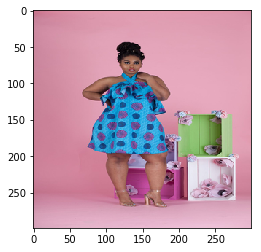

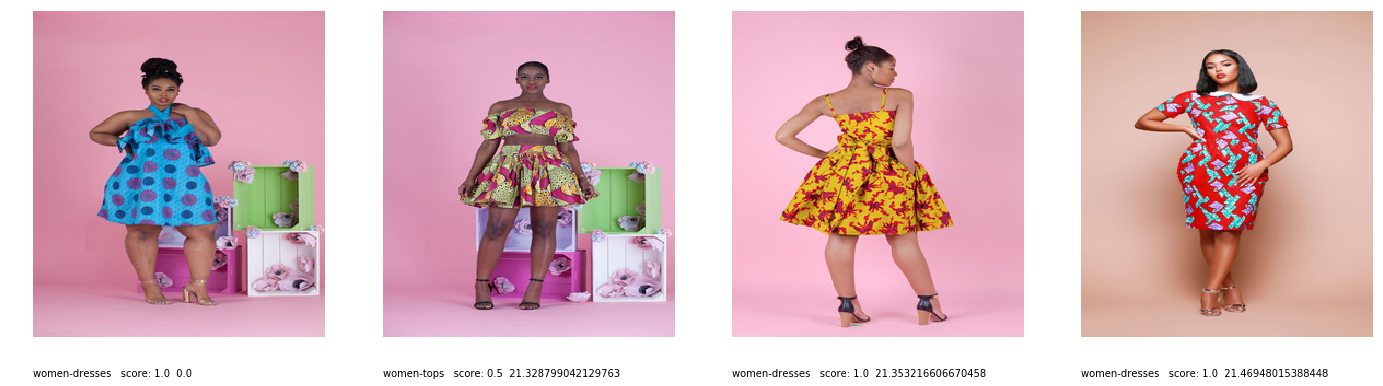

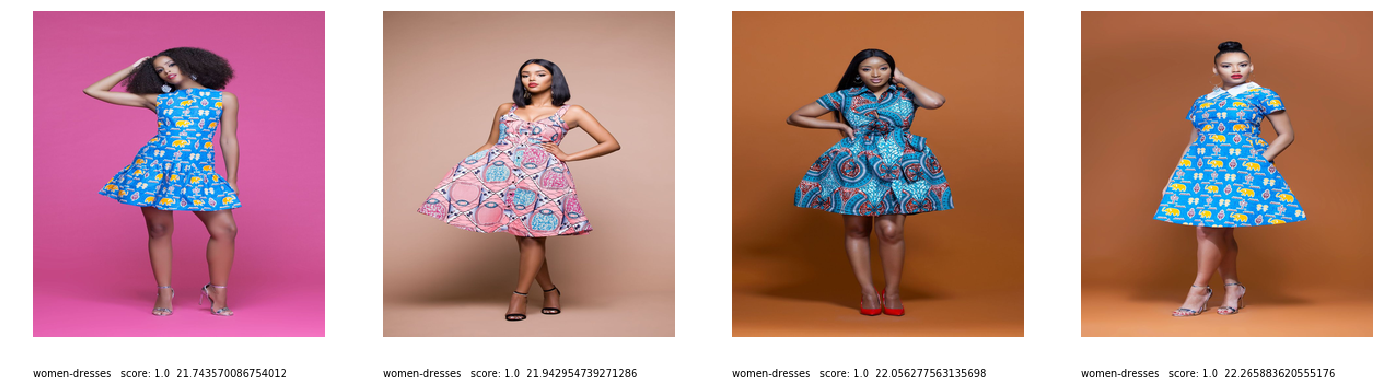

In [186]:
p = 411
num_rec =  8
plot_neighbors(cat_urls[p], train_n_set[p], cat_urls, top=num_rec, per_row=4)

In [55]:
# RUN FILE FROM HERE 

def get_neighbors(f, knn_file, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    
    X_conv_2d = get_conv_feats(f, model)
    print "X_conv_2d.shape", X_conv_2d.shape
    neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
    delete_model(model)
    return neighbors

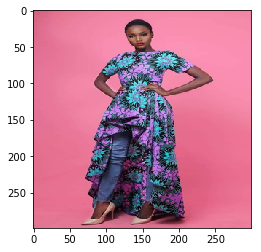

In [57]:
knn_file = 'afronet_conv_feats.pkl'
img_width, img_height = 299, 299
url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/1MST6Z8Uafrikrea/01MST6Z8Uafrikrea.jpeg"
#url = '/Users/robelmengistu/Documents/CS230_project/data/women/women-jackets/1IURM78Safrikrea/21IURM78Safrikrea.jpeg'
#url = "/Users/robelmengistu/Documents/CS230_project/data/women/women-dresses/11887377615/4african-print-wekesa-midi-dress.jpeg"
img = read_img(url) # reads an image link into a NumPy array...
n1p_img = resize_img_to_array(img, img_shape=(img_width, img_height))
imshow(n1p_img)

In [58]:
neighbors = get_neighbors(url, knn_file, top=8)

/Users/robelmengistu/anaconda2/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NearestNeighbors from version 0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


X_conv_2d.shape (1, 2048)


In [25]:
def accuracy_score (q_cat, r_cat, num_rec): 

    match_score =  1.0/num_rec
    half_match_score = (1.0/(num_rec * 2))
    
    matching_sets = [["women-dresses","women-outerwear", "women-matching-sets"], ["women-tops", "women-jackets"]]
    
    half_match_set_1 = ["women-jumpsuits", "women-pants-and-shorts","women-matching-sets","women-dresses", "women-skirts"]
    half_match_set_2 = ["women-tops", "women-jackets", "women-dresses", "women-matching-sets", "women-outerwear"]
    
    
    match_tuples = []
    for ms in matching_sets:
        for i in ms:
            for j in ms:
                if i != j: match_tuples.append((i,j))
    
    half_match_tuples = []
    for hs in [half_match_set_1, half_match_set_2]:
        for i in hs:
            for j in hs:
                if i != j: half_match_tuples.append((i,j))
    
    
    if r_cat == q_cat: return match_score
    if (r_cat, q_cat) in match_tuples: return match_score
    if (r_cat, q_cat) in half_match_tuples: return half_match_score
    return 0

In [79]:
# calc the mean avg. precision
def get_map(url, neighbors, J, num_rec=8, per_row=4):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   #TODO: change depending on data location 
    query_category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
    MAP = 0 
    accuracy = [] 
    product_recommended = []
    while (True):
        if c == num_rec: break 
        k = neighbors[1][0][i]
        #print k, X_train['product_id'][k]
        if J['product_id'][k] in product_recommended: 
            i += 1
            continue
        
        accuracy.append(accuracy_score(query_category, J['category'][k], num_rec))
        
        MAP += (sum(accuracy)/len(accuracy))
        
        i += 1
        c += 1
        product_recommended.append(J['product_id'][k])
    
    
    return MAP
        
        

In [77]:
def get_neighbors_set(f_set, knn_file):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    neighbors_set = []
    for f in f_set: 
        X_conv_2d = get_conv_feats(f, model)
        neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
        neighbors_set.append(neighbors)
    delete_model(model)
    return neighbors_set

In [78]:
CATEGORY = 6
PRODUCT_ID = 8
FILE_NAME = 9

datadir = '/Users/robelmengistu/Documents/CS230_project/data'
i = 0
products_added = []
test_urls = []

for subdir, dirs, files in os.walk(datadir):
    for img in files:
        if ".DS_" in img: continue
        path = subdir+"/" +img
        path_split = path.split("/")
        product = path_split[PRODUCT_ID]
        if "afrikrea" in product and product not in products_added:
            products_added.append(product)
            test_urls.append(path)
        else: 
            continue 
        i += 1
print len(test_urls)

4181


In [79]:
# Test Data
dresses_set = test_urls[:450]
other_set = test_urls[2750:3200]  # pants and shorts and skirts

In [80]:
dress_neighbors_set = get_neighbors_set(dresses_set, knn_file)

In [81]:
other_neighbors_set = get_neighbors_set(other_set, knn_file)

In [189]:
print "TEST SET RESULTS: "
num_rec = 8
dress_accuracy = 0 
acc_factor = 1.0/len(dresses_set)
for i in range(len(dresses_set)):
    if i == 324: 
        dress_accuracy += (0.5*acc_factor)
        continue
    acc = get_map(dresses_set[i], dress_neighbors_set[i], X_train, num_rec=num_rec, per_row=4)
    #if acc < 0.2: print i
    dress_accuracy += (acc*acc_factor)

print "Dress MAP: ", dress_accuracy


other_accuracy = 0

acc_factor = 1.0/len(other_set)
for i in range(len(other_set)):
    acc = get_map(other_set[i], other_neighbors_set[i], X_train, num_rec=num_rec, per_row=4)
    other_accuracy += (acc*acc_factor)
    if acc < 0.2: print i
    
print "Other MAP: ", other_accuracy
print "Overall MAP", (other_accuracy + dress_accuracy)/2.0

TEST SET RESULTS: 
Dress MAP:  0.735096560847
4
5
9
25
28
29
44
47
51
53
57
58
65
67
70
74
83
84
85
88
89
90
92
96
105
116
119
123
132
137
141
142
147
148
153
155
157
162
164
165
166
183
185
197
210
224
227
228
288
296
309
316
328
357
361
393
443
444
Other MAP:  0.477018683862
Overall MAP 0.606057622354
